`Reference`
- A survey on Deep Learning Advances on Different 3D DataRepresentations - [pdf](https://arxiv.org/pdf/1808.01462.pdf)
- VoxNet: A 3D Convolutional Neural Network for Real-Time Object Recognition - [pdf](https://www.ri.cmu.edu/pub_files/2015/9/voxnet_maturana_scherer_iros15.pdf)
- FusionNet: 3D Object Classification Using MultipleData Representations - [pdf](https://3ddl.cs.princeton.edu/2016/papers/Hegde_Zadeh.pdf)
- Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction - [pdf](https://arxiv.org/pdf/2007.13224.pdf)

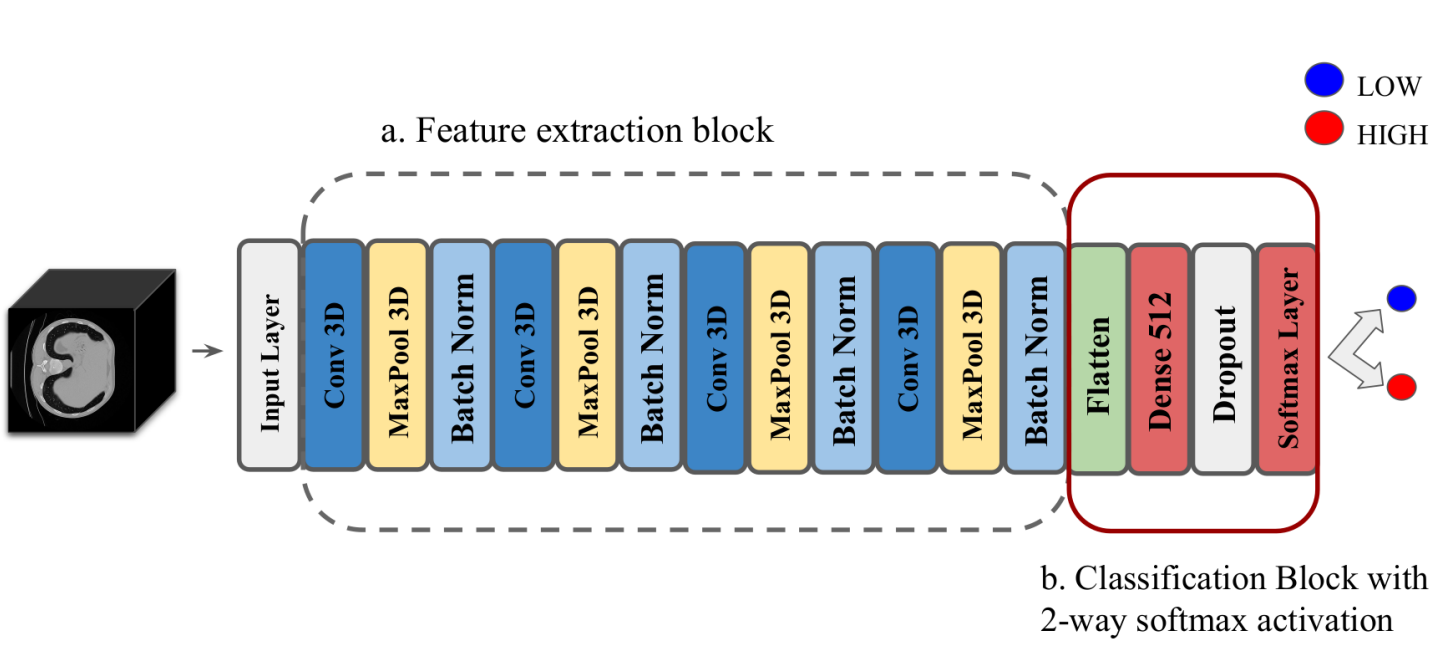

# 준비

## 라이브러리 호출

In [1]:
import os
import gzip
import zipfile
import random
from termcolor import colored

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import nibabel as nib
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils

## 데이터 다운로드

In [2]:
file_path = "D:/Dataset/dataset/keras_example"

In [4]:
# Make a directory to store the data.
os.makedirs(file_path+"/MosMedData")

url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(file_path, "CT-0.zip")
keras.utils.get_file(filename, url)

with zipfile.ZipFile(filename, "r") as z_fp:
    z_fp.extractall(file_path+"/MosMedData/")

url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(file_path, "CT-23.zip")
keras.utils.get_file(filename, url)

with zipfile.ZipFile(filename, "r") as z_fp:
    z_fp.extractall(file_path+"/MosMedData/")
    
os.remove(file_path+"/CT-23.zip")
os.remove(file_path+"/CT-0.zip")

1045162547/1045162547 [==============================] - 143s 0us/step


## 데이터 로드, 전처리

In [5]:
# nifti 파일 읽기
def read_nifti_file(filepath):
    """Read and load volume"""
    filepath
    scan = nib.load(filepath) # Read file
    scan = scan.get_fdata() # Get raw data
    return scan

# 정규화
def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

# rotate the volumes by 90 degrees, so the orientation is fixed
# scale the HU values to be between 0 and 1.
# resize width, height and depth.
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    
    img = ndimage.rotate(img, 90, reshape=False) # Rotate
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1) # Resize across z-axis
    return img

def process_scan(path):
    """Read and resize volume"""
    volume = read_nifti_file(path) # Read scan
    volume = normalize(volume) # Normalize
    volume = resize_volume(volume) # Resize width, height and depth
    return volume

In [6]:
#no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(file_path,"MosMedData/CT-0", x)
    for x in os.listdir(file_path+"/MosMedData/CT-0")
]
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(file_path, "MosMedData/CT-23", x)
    for x in os.listdir(file_path+"/MosMedData/CT-23")
]
print(colored("CT scans with normal lung tissue\t:","red"), str(len(normal_scan_paths)))
print(colored("CT scans with abnormal lung tissue\t:","red"), str(len(abnormal_scan_paths)))

print(colored("CT scans original image shape\t\t:","red"), read_nifti_file(normal_scan_paths[0]).shape)

CT scans with normal lung tissue	: 100
CT scans with abnormal lung tissue	: 100
CT scans original image shape		: (512, 512, 43)


## Train/Valid/Test 분리

In [7]:
import random
random.shuffle(normal_scan_paths)
random.shuffle(abnormal_scan_paths)

# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

In [8]:
# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


## 데이터 셋과 증강

In [9]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""
    def scipy_rotate(volume):
        angles = [-20, -10, -5, 5, 10, 20] # define some rotation angles
        angle = random.choice(angles) # pick angles at random
        volume = ndimage.rotate(volume, angle, reshape=False) # rotate volume
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume
    
    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [ ]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 1
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

## Sample

In [ ]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print(colored("Dimension of the CT scan is:","red"), image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray");

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

# 4 rows and 10 columns for 100 slices of the CT scan.
print(colored("Sample 60 images (100 slices of CT scan)","red"), image.shape)
plot_slices(6, 10, 256, 256, image[:, :, :60])

# 모델링

In [ ]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1), name="input")
    x = layers.Conv3D(filters=64, kernel_size=3, activation="leaky_relu", name="conv3D_1")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="leaky_relu", name="conv3D_2")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="leaky_relu", name="conv3D_3")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="leaky_relu", name="conv3D_4")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="leaky_relu", name="FC")(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation="leaky_relu", name="FC2")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(units=1, activation="sigmoid", name="output")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()
utils.plot_model(model, to_file="../tmp/3d_CNN.png",show_shapes=True, dpi=70)

# 훈련

In [ ]:
# Compile model.
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint("model/3d_image_classification.h5", save_best_only=True)

# Train the model, doing validation at the end of each epoch
epochs = 100
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    callbacks=[checkpoint_cb]
)

# 결과

In [ ]:
model.load_weights("./model/3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

In [ ]:
from Myfunc import show_lcurve
show_lcurve([history], [""], ["b"],x_itv=10, size=(18,8), lw=2)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score

y_pred=model.predict(validation_dataset)
y_pred_arg = tf.where(y_pred>=0.5, 1, 0)[:,0]

print(colored("Test Acc\t:","red"),accuracy_score(y_val, y_pred_arg),"\n\n")
print(colored("Classfication_report :\n", "red"), classification_report(y_val, y_pred_arg))
plt.figure(figsize=(8,8))
plt.title("Confusion_matrix", fontsize=20, color="red")
sns.heatmap(confusion_matrix(y_val, y_pred_arg), annot=True, cmap="PuBu");